# Importando Bibliotecas

In [93]:
import pandas as pd
import numpy as np

from scipy.stats import normaltest

from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer

import skopt

In [2]:
import warnings

warnings.filterwarnings('ignore')

# Lendo os Dados

In [3]:
df = pd.read_csv('train.csv')
df

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


# EDA

### Target

In [4]:
df['target'].value_counts()/len(df)*100

0    89.951
1    10.049
Name: target, dtype: float64

Temos claramente um problema de dados desbalanceados

### Overview das Features

#### Valores Nulos

In [5]:
(df.drop(['ID_code','target'],axis=1).isnull().sum()/len(df)*100).sort_values(ascending=False)

var_0      0.0
var_137    0.0
var_127    0.0
var_128    0.0
var_129    0.0
          ... 
var_69     0.0
var_70     0.0
var_71     0.0
var_72     0.0
var_199    0.0
Length: 200, dtype: float64

#### Valores Únicos

In [6]:
(df.drop(['ID_code','target'],axis=1).nunique()/len(df)*100).sort_values(ascending=False)

var_45     84.9840
var_117    82.2345
var_74     80.5290
var_61     79.6845
var_97     79.3695
            ...   
var_12      4.7805
var_103     4.6880
var_108     4.2625
var_91      3.9810
var_68      0.2255
Length: 200, dtype: float64

#### Correlação

In [7]:
df_corr = df.drop(['ID_code'], axis=1).corr()
df_corr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


In [8]:
df_corr_features = df_corr.drop('target', axis=1)
df_corr_features = df_corr_features.drop('target', axis=0)
df_corr_features

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,-0.002613,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,-0.000832,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,-0.001932,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,-0.000826,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,0.000049,0.004549,0.001194,-0.000918,...,0.001514,0.004357,0.003347,0.000813,-0.000068,0.003706,0.000513,-0.000046,-0.001821,-0.000786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,-0.000868,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,0.000052,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,0.003701,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,0.002343,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


In [9]:
corr_array = df_corr_features.values.flatten()
corr_array = corr_array[corr_array != 1]
corr_array

array([-0.0005437 ,  0.00657283,  0.00380076, ...,  0.00060689,
        0.00499055, -0.00473056])

In [10]:
print(f'Min correlation = {corr_array.min()}')
print(f'Max correlation = {corr_array.max()}')

Min correlation = -0.009844361358419583
Max correlation = 0.009713658349533924


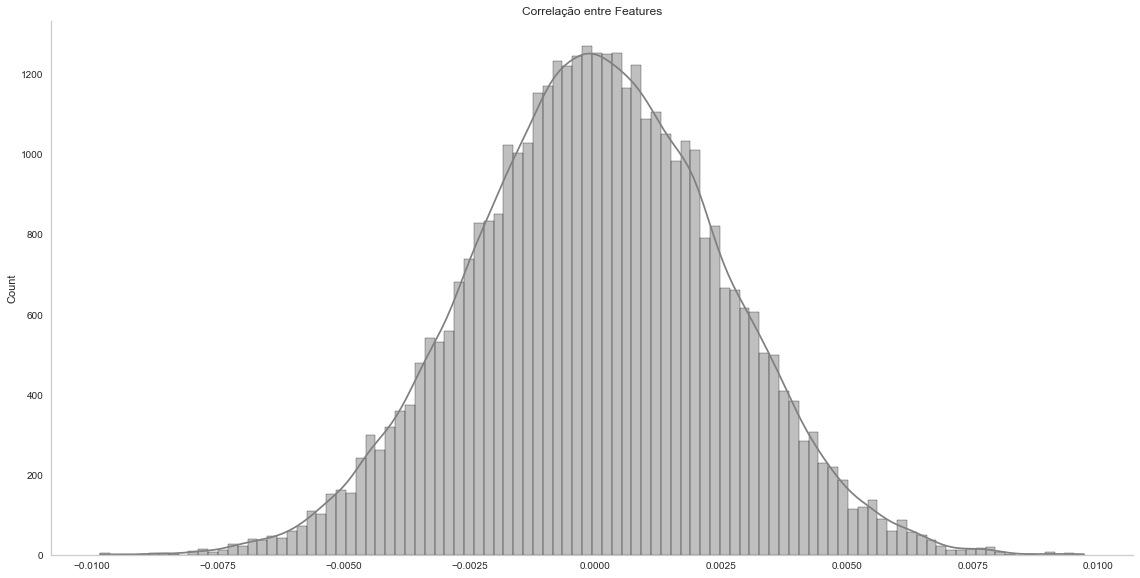

In [11]:
sns.displot(data=corr_array, kde=True, height=8, aspect=2, color='gray')
plt.grid(False)
plt.title("Correlação entre Features")
plt.show()

In [12]:
df_corr_target = df_corr[['target']]
df_corr_target = df_corr_target.drop('target', axis=0)
df_corr_target

,target
var_0,0.052390
var_1,0.050343
var_2,0.055870
var_3,0.011055
var_4,0.010915
...,...
var_195,0.028285
var_196,0.023608
var_197,-0.035303
var_198,-0.053000


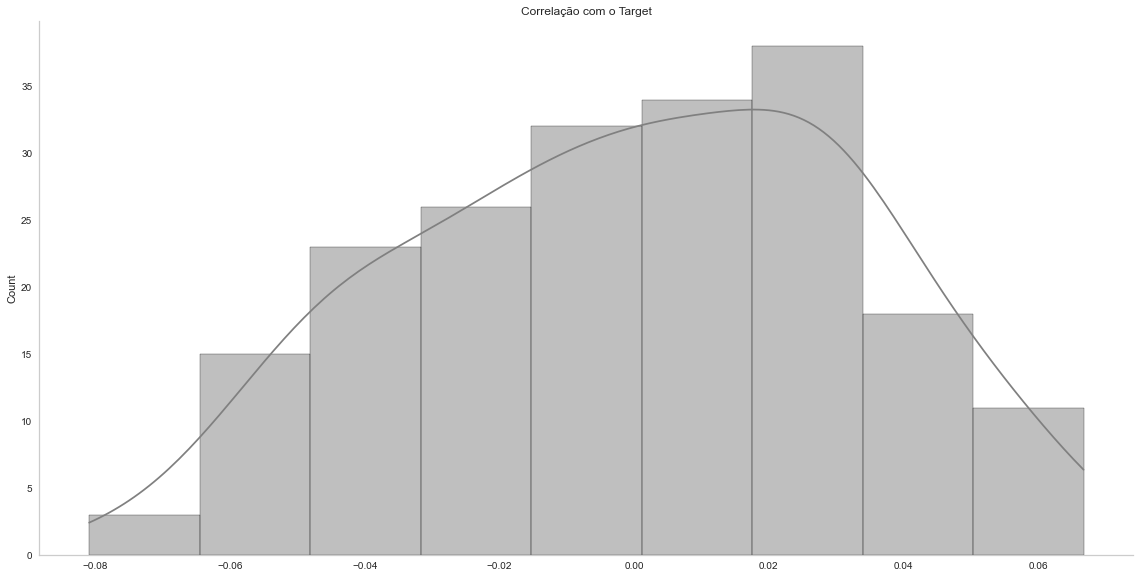

In [13]:
sns.displot(data=df_corr_target.values.flatten(), kde=True, height=8, aspect=2, color='gray')
plt.grid(False)
plt.title("Correlação com o Target")
plt.show()

#### Teste de Normalidade

- Ho: A amostra **está** normalmente distribuída.(P>0.05)
- H1: A amostra **NÃO está** normalmente distribuída.

In [14]:
p_valor = []

def normal_teste(feature, array, alpha=0.05):
  p = normaltest(array).pvalue
  print(p)
  p_valor.append({
      'feature': col,
      'p_valor': p
  })
  if p < alpha:
    print(f'Rejeita H0. A feature {feature} NÃO está normalmente distribuída')
  else:
    print(f'Aceita H0. A feature {feature} está normalmente distribuída. P-valor = {p} >= {alpha}')

In [15]:
for col in df.drop(['ID_code','target'],axis=1).columns:
  array = df[col].values
  normal_teste(col, array)

0.0
Rejeita H0. A feature var_0 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_1 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_2 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_3 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_4 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_5 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_6 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_7 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_8 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_9 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_10 NÃO está normalmente distribuída
6.537754696180333e-281
Rejeita H0. A feature var_11 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_12 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_13 NÃO está normalmente distribuída
0.0
Rejeita H0. A feature var_14 NÃO está normalmente distribuída
0

In [16]:
p_valor = pd.DataFrame(p_valor)
p_valor

,feature,p_valor
0,var_0,0.0
1,var_1,0.0
2,var_2,0.0
3,var_3,0.0
4,var_4,0.0
...,...,...
195,var_195,0.0
196,var_196,0.0
197,var_197,0.0
198,var_198,0.0


In [17]:
var_min = p_valor.loc[p_valor['p_valor'] == p_valor['p_valor'].min()]['feature'].values[0]

In [18]:
var_max = p_valor.loc[p_valor['p_valor'] == p_valor['p_valor'].max()]['feature'].values[0]

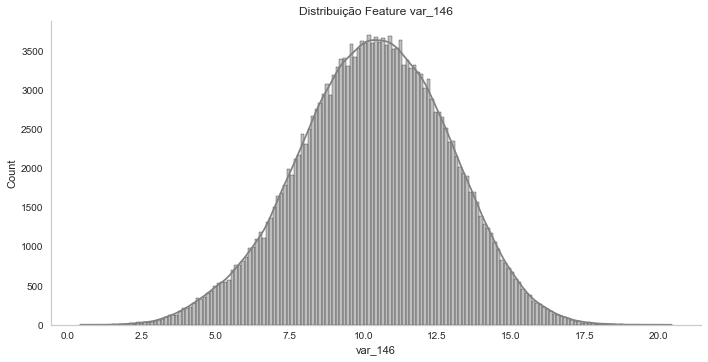

In [19]:
sns.displot(df[var_max], kde=True, aspect=2, color='gray')
plt.grid(False)
plt.title(f'Distribuição Feature {var_max}')
plt.show()

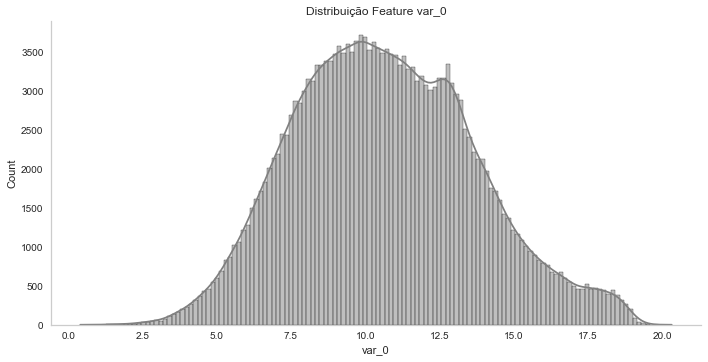

In [20]:
sns.displot(df[var_min], kde=True, aspect=2, color='gray')
plt.grid(False)
plt.title(f'Distribuição Feature {var_min}')
plt.show()

# Modelo

In [21]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [22]:
X = df.drop(['ID_code','target'], axis=1)
y = df['target']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=123)

In [24]:
X_train_standard = StandardScaler().fit_transform(X_train)

In [25]:
X_test_standard = StandardScaler().fit_transform(X_test)

### Sampling

In [26]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)

In [27]:
X_res_standard = StandardScaler().fit_transform(X_res)

### Sem PCA - Dados Balanceados

In [28]:
modelos = [LogisticRegression(), SGDClassifier(), LGBMClassifier()]

In [29]:
for modelo in modelos:
  scores = cross_val_score(modelo, X_res_standard, y_res, cv=skf, scoring = 'roc_auc')
  print(f'''
  Modelo: {modelo}
  CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
  ''')


  Modelo: LogisticRegression()
  CV AUC Score: 85.59% +/- 0.59%'
  

  Modelo: SGDClassifier()
  CV AUC Score: 83.03% +/- 0.66%'
  

  Modelo: LGBMClassifier()
  CV AUC Score: 86.16% +/- 0.35%'
  


In [30]:
modelo = LGBMClassifier()

modelo.fit(X_res_standard, y_res)

LGBMClassifier()

In [31]:
y_pred_test = modelo.predict(X_test_standard)

accuracy_test = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_pred_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 60.9%
      AUC = 73.92%
      


### Sem PCA - Dados Desbalanceados

In [32]:
for modelo in modelos:
  scores = cross_val_score(modelo, X_train_standard, y_train, cv=skf, scoring = 'roc_auc')
  print(f'''
  Modelo: {modelo}
  CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
  ''')


  Modelo: LogisticRegression()
  CV AUC Score: 85.86% +/- 0.44%'
  

  Modelo: SGDClassifier()
  CV AUC Score: 83.17% +/- 0.46%'
  

  Modelo: LGBMClassifier()
  CV AUC Score: 86.48% +/- 0.36%'
  


In [33]:
modelo = LGBMClassifier()

modelo.fit(X_train_standard, y_train)

LGBMClassifier()

In [34]:
y_pred_test = modelo.predict(X_test_standard)

accuracy_test = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_pred_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 90.67%
      AUC = 54.9%
      


### Com PCA

In [35]:
pca = PCA(n_components = 0.99999)

In [36]:
X_pca = pca.fit_transform(X_res_standard)

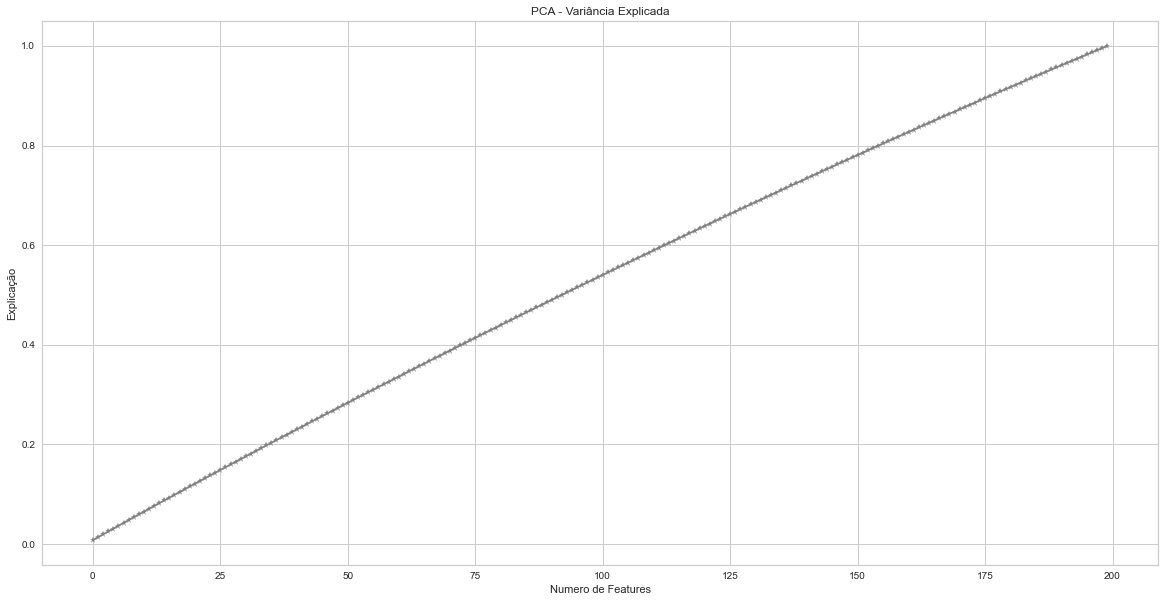

In [37]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '*-', color='gray')
plt.title('PCA - Variância Explicada')
plt.xlabel('Numero de Features')
plt.ylabel('Explicação')
plt.show()

#### 90% de Explicação

In [38]:
pca = PCA(n_components=180)
X_pca_90 = pca.fit_transform(X_res_standard)

In [39]:
for modelo in modelos:
  scores = cross_val_score(modelo, X_pca_90, y_res, cv=skf, scoring = 'roc_auc')
  print(f'''
  Modelo: {modelo}
  CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
  ''')


  Modelo: LogisticRegression()
  CV AUC Score: 85.6% +/- 0.59%'
  

  Modelo: SGDClassifier()
  CV AUC Score: 83.12% +/- 0.71%'
  

  Modelo: LGBMClassifier()
  CV AUC Score: 85.79% +/- 0.49%'
  


In [40]:
modelo = LGBMClassifier()
modelo.fit(X_pca_90, y_res)

LGBMClassifier()

In [41]:
X_test_pca_90 = pca.transform(X_test_standard)

In [42]:
y_pred_test = modelo.predict(X_test_pca_90)

accuracy_test = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_pred_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 61.49%
      AUC = 74.35%
      


#### 80% de Explicação

In [43]:
pca = PCA(n_components=150)
X_pca_80 = pca.fit_transform(X_res_standard)

In [44]:
for modelo in modelos:
  scores = cross_val_score(modelo, X_pca_80, y_res, cv=skf, scoring = 'roc_auc')
  print(f'''
  Modelo: {modelo}
  CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
  ''')


  Modelo: LogisticRegression()
  CV AUC Score: 85.53% +/- 0.57%'
  

  Modelo: SGDClassifier()
  CV AUC Score: 82.97% +/- 0.78%'
  

  Modelo: LGBMClassifier()
  CV AUC Score: 85.51% +/- 0.55%'
  


In [45]:
modelo = LGBMClassifier()
modelo.fit(X_pca_80, y_res)

LGBMClassifier()

In [46]:
X_test_pca_80 = pca.transform(X_test_standard)

In [47]:
y_pred_test = modelo.predict(X_test_pca_80)

accuracy_test = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_pred_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 61.3%
      AUC = 73.94%
      


#### 70% de Explicação

In [48]:
pca = PCA(n_components=125)
X_pca_70 = pca.fit_transform(X_res_standard)

In [49]:
for modelo in modelos:
  scores = cross_val_score(modelo, X_pca_70, y_res, cv=skf, scoring = 'roc_auc')
  print(f'''
  Modelo: {modelo}
  CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
  ''')


  Modelo: LogisticRegression()
  CV AUC Score: 85.44% +/- 0.6%'
  

  Modelo: SGDClassifier()
  CV AUC Score: 83.06% +/- 0.89%'
  

  Modelo: LGBMClassifier()
  CV AUC Score: 85.45% +/- 0.62%'
  


In [50]:
modelo = LGBMClassifier()
modelo.fit(X_pca_70, y_res)

LGBMClassifier()

In [51]:
X_test_pca_70 = pca.transform(X_test_standard)

In [52]:
y_pred_test = modelo.predict(X_test_pca_70)

accuracy_test = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_pred_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 61.4%
      AUC = 73.97%
      


#### 60% de Explicação

In [53]:
pca = PCA(n_components=110)
X_pca_60 = pca.fit_transform(X_res_standard)

In [54]:
for modelo in modelos:
  scores = cross_val_score(modelo, X_pca_60, y_res, cv=skf, scoring = 'roc_auc')
  print(f'''
  Modelo: {modelo}
  CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
  ''')


  Modelo: LogisticRegression()
  CV AUC Score: 85.28% +/- 0.59%'
  

  Modelo: SGDClassifier()
  CV AUC Score: 83.13% +/- 0.82%'
  

  Modelo: LGBMClassifier()
  CV AUC Score: 85.33% +/- 0.63%'
  


In [55]:
modelo = LGBMClassifier()
modelo.fit(X_pca_60, y_res)

LGBMClassifier()

In [56]:
X_test_pca_60 = pca.transform(X_test_standard)

In [57]:
y_pred_test = modelo.predict(X_test_pca_60)

accuracy_test = round(metrics.accuracy_score(y_test, y_pred_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_pred_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 61.37%
      AUC = 74.02%
      


Por incrível que pareça, com o PCA ganhamos em **performance** e **velocidade**. Porém a melhora de performance não foi lá essas coisas, 0,25%.

# LGBM

In [58]:
rs_params = {
'learning_rate': skopt.space.Real(0.01, 0.5, prior='log-uniform'),
'max_depth': skopt.space.Integer(1, 30),
'num_leaves': skopt.space.Integer(10, 200),
'feature_fraction': skopt.space.Real(0.1, 1.0),
'subsample': skopt.space.Real(0.1, 1.0)
}

In [59]:
rs = RandomizedSearchCV(estimator=LGBMClassifier(), param_distributions=rs_params, cv=skf, scoring='roc_auc', verbose=1, )
rs.fit(X_res_standard, y_res)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=LGBMClassifier(),
                   param_distributions={'feature_fraction': Real(low=0.1, high=1.0, prior='uniform', transform='identity'),
                                        'learning_rate': Real(low=0.01, high=0.5, prior='log-uniform', transform='identity'),
                                        'max_depth': Integer(low=1, high=30, prior='uniform', transform='identity'),
                                        'num_leaves': Integer(low=10, high=200, prior='uniform', transform='identity'),
                                        'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='identity')},
                   scoring='roc_auc', verbose=1)

In [60]:
lgbm_tuned = rs.best_estimator_
lgbm_tuned

LGBMClassifier(feature_fraction=[0.43243728699429773],
               learning_rate=[0.15934102803001204],
               max_depth=array([26], dtype=int64),
               num_leaves=array([35], dtype=int64),
               subsample=[0.7589762939330379])

In [61]:
scores = cross_val_score(lgbm_tuned, X_res_standard, y_res, cv=skf, scoring = 'roc_auc')
print(f'''
Modelo: {modelo}
CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
''')

[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773

In [62]:
y_predict_test = lgbm_tuned.predict(X_test_standard)

accuracy_test = round(metrics.accuracy_score(y_test, y_predict_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_predict_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 61.49%
      AUC = 74.68%
      


### Clusterização

##### KMeans

In [71]:
df

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [72]:
X_cluster = df.drop(['ID_code', 'target'], axis=1)

**Elbow**

1 1284430056.343898
2 1221689229.5583212
3 1206446531.742231
4 1193191664.4598756
5 1184286785.8117414
6 1176909558.6512115
7 1170012060.8478165
8 1164673378.0450237
9 1160035561.9507952
10 1155745353.216826


Text(0, 0.5, 'WCSS')

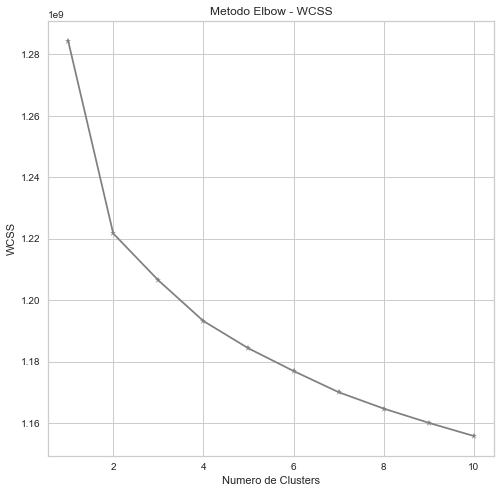

In [83]:
plt.figure(figsize=(8,8))

wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_cluster)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss,'*-', color='gray')
plt.title('Metodo Elbow - WCSS')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS')

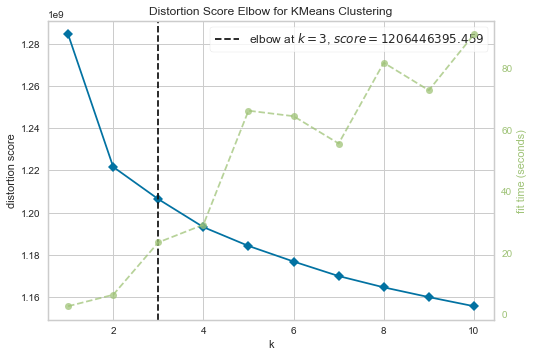

In [84]:
vis=KElbowVisualizer(kmeans, k=(1, 11))
vis.fit(X_cluster)
vis.show();

**Davies-Bouldin**

2 4.401751503808555
3 5.651306116387858
4 5.453166801736218
5 5.343472614204336
6 5.780379184248616
7 5.60529808778351
8 5.538572258845713
9 5.526219016859917
10 5.452165198297755


Text(0, 0.5, 'Score')

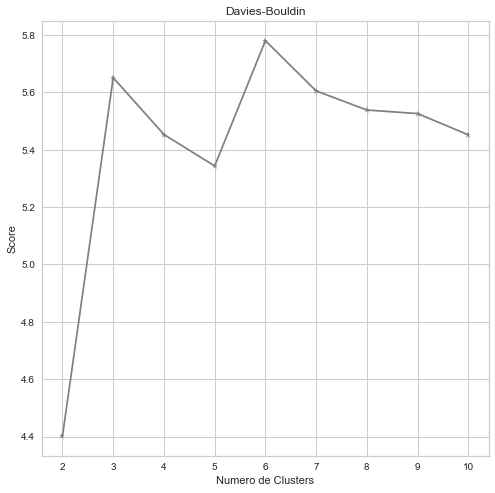

In [76]:
plt.figure(figsize=(8,8))

davies_bouldin_scores = []
n_cluster_list = np.arange(2,11).astype(int)

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X_cluster)
    score = davies_bouldin_score(X_cluster, kmeans.labels_)
    davies_bouldin_scores.append(score)
    print (n_cluster,score)

plt.plot(range(2, 11), davies_bouldin_scores,'*-', color='gray')
plt.title('Davies-Bouldin')
plt.xlabel('Numero de Clusters')
plt.ylabel('Score')

In [109]:
k = 2

kmeans = KMeans(n_clusters=k)

In [110]:
cluster_found = kmeans.fit_predict(X_cluster)

In [111]:
davies_bouldin = davies_bouldin_score(X_cluster, cluster_found)
davies_bouldin

4.40178319593127

# LightGBM com Cluster

In [112]:
df['cluster'] = cluster_found

In [113]:
X = df.drop(['ID_code','target'], axis=1)
y = df['target']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=123)

In [115]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)

In [116]:
pipe = Pipeline([
    ('pre-processor', StandardScaler()),
    ('model', lgbm_tuned)
])

In [117]:
scores = cross_val_score(pipe, X_res, y_res, cv=skf, scoring = 'roc_auc')
print(f'''
CV AUC Score: {round(scores.mean()*100,2)}% +/- {round(scores.std()*100,2)}%'
''')

[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773
[LightGBM] [Warning] feature_fraction is set=0.43243728699429773

In [118]:
pipe.fit(X_res, y_res)

[LightGBM] [Warning] feature_fraction is set=0.43243728699429773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43243728699429773


Pipeline(steps=[('pre-processor', StandardScaler()),
                ('model',
                 LGBMClassifier(feature_fraction=[0.43243728699429773],
                                learning_rate=[0.15934102803001204],
                                max_depth=array([26], dtype=int64),
                                num_leaves=array([35], dtype=int64),
                                subsample=[0.7589762939330379]))])

In [119]:
y_predict_test = pipe.predict(X_test)

accuracy_test = round(metrics.accuracy_score(y_test, y_predict_test)*100,2)

auc_test = round(metrics.roc_auc_score(y_test, y_predict_test)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      AUC = {auc_test}%
      ''')


      As métricas do teste foram:
      Acurária = 78.47%
      AUC = 78.61%
      


---
# Submission

In [130]:
submission = pd.read_csv('test.csv')
submission

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122


In [131]:
submission['cluster'] = kmeans.predict(submission.drop('ID_code', axis=1))
submission

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,cluster
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,1
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,1
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,1
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801,1
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689,1
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762,1
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122,1


In [132]:
submission['target'] = pipe.predict(submission.drop('ID_code', axis=1))
submission

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,cluster,target
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,1,1
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,1,1
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0,1
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,1,0
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801,1,1
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689,1,0
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762,1,0
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122,1,0


In [133]:
submission = submission[['ID_code', 'target']]
submission

,ID_code,target
0,test_0,1
1,test_1,1
2,test_2,1
3,test_3,0
4,test_4,0
...,...,...
199995,test_199995,1
199996,test_199996,0
199997,test_199997,0
199998,test_199998,0


In [134]:
submission.to_csv('submission.csv', index=None)

_**Kaggle Score**_: 0.78467